# Machine Learning Practice on Titanic Dataset

In [1]:
# Imports:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler # KNN gets better performance from it.
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Importing our data:
data  = pd.read_csv("../data/titanic.csv") # reading the data.
info = data.info()
print(info) # Basic info about the data-set, seeing what is the data type.
print("Null values:",data.isnull().sum()) # Checking how many missing in each column.
print("Duplicated",data.duplicated().sum()) # Checking how many duplicates in each column.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None
Null values: PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         

In [59]:
# Data Cleaning and Feature Engineering
def preprocess_data(df):
    df.drop(columns=["PassengerId", "Name", "Ticket", "Cabin"], inplace = True) #inplace true will alter the original dataframe.
    df["Embarked"] = df["Embarked"].fillna("S")
    df.drop(columns=["Embarked"], inplace=True)

    # Changing object dtype to binary values
    df["Sex"] = df["Sex"].map({'male':1,"female":0})

    # Feature Engineer
    df["FamilySize"] = df["SibSp"] + df["Parch"] # adding sibling count with parent count.
    df["IsAlone"] = np.where(df["FamilySize"] == 0, 1, 0) # np.where(condition, value_if_true, value_if_false)
    # qcut = quantile cut. It divides data into bins with equal number of samples in each bin.
    # Takes the Fare column, Cuts it into 4 quantile-based groups, Assigns labels 0, 1, 2, 3 for each bin.
    # Bin 0 = very low fare, Bin 1 = low-medium fare, Bin 2 = medium-high fare, Bin 3 = very high fare
    df["FareBin"] = pd.qcut(df["Fare"], 4, labels=False)  
    # Creating an age range using bins. Custom age bin : cut, quartile: qcut
    # Bin Label	Age Range
    # 0	0–12 (children)
    # 1	12–20 (teenagers)
    # 2	20–30 (young adults)
    # 3	30–60 (adults)
    # 4	60+ (seniors)
    df["AgeBin"] = pd.cut(df["Age"], bins=[0, 12, 20, 30, 60, np.inf], labels = False)
    
    return df

In [60]:
# Some talk about feature engineering.
# If a raw column doesn't directly reveal certain patterns, you create a more meaningful version of it.
# Example:
# “Age” is continuous → but survival might not depend linearly on age
# Babies, teens, adults, seniors survive differently → so you create AgeBin

# Raw continuous features can be noisy.
# Binning reduces noise by smoothing values into stable intervals.
# Example:
# Age 22, 23, 24 → all become “20–30 group”

# Titanic dataset has SibSp (siblings/spouses) and Parch (parents/children)
# Alone, each feature is weak
# Combined → they tell you family size
# Then you realize:
# People with large families might be harder to save
# People alone might behave differently

# When domain knowledge suggests important groupings
# This is the most powerful reason.
# Titanic examples:
# Children had priority → so “AgeBin” makes sense
# Women survived more → sex is a key feature (known ahead of time)
# People in 1st class had advantages → Pclass matters
# Being alone vs with family affects survival → create “IsAlone”
# Domain understanding lets you engineer features that matter.

In [61]:
# Fill missing ages:
def fill_missing_ages(df):
    df = df.copy()
    age_fill_map = {}
    # for every passenger class in the passenger class column which is unique:
    for pclass in df["Pclass"].unique():
        if pclass not in age_fill_map: # if that passenger class is not in the age_fill dict
            age_fill_map[pclass] = df[df["Pclass"]== pclass]["Age"].median() # key that class as a key in the dict and the value to be the median age of that pclass.
    df["Age"] = df.apply(lambda row: age_fill_map[row["Pclass"]] if pd.isnull(row["Age"]) else row["Age"], axis=1) # df.apply(function, axis=1) Processes each row one-by-one.
    return df

In [62]:
# Using the functions:
data = fill_missing_ages(data)
data = preprocess_data(data)

In [63]:
# Create Feature / Target Variables
X = data.drop(columns=["Survived"])
y = data["Survived"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [64]:
# PIPELINE + GRID SEARCH
pipeline = Pipeline([
    ("scaler", MinMaxScaler()),
    ("model", KNeighborsClassifier())
])

param_grid = {
    "model__n_neighbors": range(1, 21),
    "model__metric": ["euclidean", "manhattan", "minkowski"],
    "model__weights": ["uniform", "distance"]
}

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

In [65]:
# Evaluation:
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy*100:.2f}%")
print("Confusion Matrix:")
print(matrix)

print("\nBest Hyperparameters:")
print(grid_search.best_params_)

Accuracy: 81.61%
Confusion Matrix:
[[116  18]
 [ 23  66]]

Best Hyperparameters:
{'model__metric': 'manhattan', 'model__n_neighbors': 5, 'model__weights': 'uniform'}


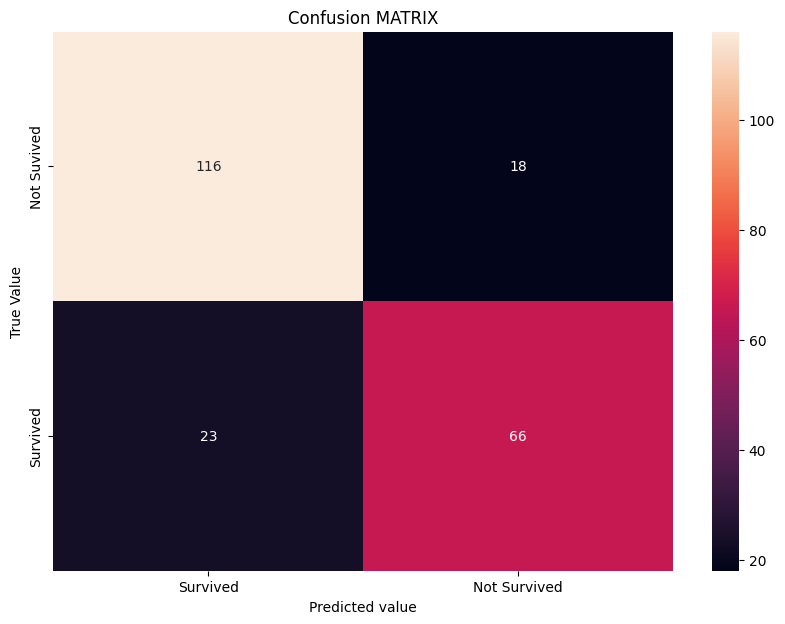

In [66]:
# Plotting Graphs:
def plot_model(matrix):
    plt.figure(figsize=(10,7))
    sns.heatmap(matrix, annot=True, fmt="d", xticklabels=["Survived", "Not Survived"],
                yticklabels=["Not Suvived", "Survived"])
    plt.title("Confusion MATRIX")
    plt.xlabel("Predicted value")
    plt.ylabel("True Value")
    plt.show()

plot_model(matrix)

In [67]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    best_model, X_test, y_test, n_repeats=10, random_state=42, scoring='accuracy'
)

# Display importance
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': result.importances_mean
}).sort_values(by='importance', ascending=False)

print(importance_df)

      feature  importance
1         Sex    0.190583
0      Pclass    0.052915
2         Age    0.030045
8     FareBin    0.025561
9      AgeBin    0.022870
7     IsAlone    0.018834
4       Parch    0.016143
3       SibSp    0.012556
6  FamilySize    0.012556
5        Fare    0.010314
